## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

from sklearn.preprocessing import StandardScaler

import pickle

from numpy.random import seed

from tensorflow import set_random_seed

Using TensorFlow backend.


In [2]:
seed(2019)
set_random_seed(2019)

## Helper Functions

In [3]:
def calc_RMSE(validation_data, prediction_data):
   """
   Calculate RMSE
   """
   a = np.array(validation_data)
   b = np.array(prediction_data)

   return np.sqrt(np.mean((b-a)**2))

In [4]:
def get_fuller_test(series):
    values = series.values
    result = adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [5]:
def make_plots(data, lags=None):
    '''
    plotting the data with specified number of lags.
    plotting raw data, then ACF and PACF
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax = raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags = lags, ax = acf)
    smt.graphics.plot_pacf(data, lags = lags, ax = pacf)
    sns.despine()
    plt.tight_layout()

In [6]:
def make_plots_2(data, lags=None):
    '''
    plotting rolling mean, rolling std and original as per number of lags
    '''
    rolling_mean = data.rolling(window = lags).mean()
    rolling_std = data.rolling(window = lags).std()
    
    original = plt.plot(data, color='black',label = 'Original Timeseries')
    mean = plt.plot(rolling_mean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolling_std, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Original, Rolling Mean, Standard Deviation')
    sns.despine()
    plt.show()

In [7]:
def split_train_test_chronological(df, ratio = 0.9):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    '''
    
    size = len(df) * ratio
    size_round = round(size)
    
    df_train = df[0:(size_round)]
    df_test = df[size_round:]
    
    return df_train, df_test

## Importing data

In [8]:
df_bitcoin_price = pd.read_pickle('../crypto_currency_and_market_value_history/data/bitcoin_4_year_hourly_history_df.pickle')

In [9]:
df_bitcoin_price.head(3)

,timestamp,open,high,low,close,volume (btc),volume (currency),weighted price
0,2015-05-31 00:00:00,232.11,232.11,231.92,231.92,223.37,51822.18,232.00
1,2015-05-31 01:00:00,231.88,232.32,231.87,232.32,217.49,50452.68,231.98
2,2015-05-31 02:00:00,231.97,232.51,231.88,232.51,46.45,10782.23,232.14


In [10]:
df_vix_daily = pd.read_pickle('../crypto_currency_and_market_value_history/data/vix_volatility_daily_change_history_df.pickle')


In [11]:
df_vix_daily.head(3)

,trade date,open,high,low,close,settle,change,total volume
0,2019-06-07,-0.014837,-0.019264,-0.006116,0.006591,0.015175,-2.666667,-0.066600
1,2019-06-06,-0.023754,-0.021143,-0.015060,0.002402,-0.009023,-0.750000,-0.038795
2,2019-06-05,-0.054247,-0.047360,-0.034884,-0.032539,-0.034833,-0.428571,-0.149433


In [12]:
df_vix_hourly = pd.read_pickle('../crypto_currency_and_market_value_history/data/vix_volatility_hourly_history_df.pickle')


In [13]:
df_vix_hourly.head(3)

,Local time,Open,High,Low,Close,Volume,local_time
0,26.01.2017 00:00:00.000 GMT-0800,19.14,19.14,19.14,19.14,0.0,2017-01-25 16:00:00+00:00
1,26.01.2017 01:00:00.000 GMT-0800,19.14,19.14,19.14,19.14,0.0,2017-01-25 17:00:00+00:00
2,26.01.2017 02:00:00.000 GMT-0800,19.14,19.14,19.14,19.14,0.0,2017-01-25 18:00:00+00:00


In [14]:
# df_vix_hourly.local_time.value_counts()

In [15]:
df_gold = pd.read_csv('../crypto_currency_and_market_value_history/data/gold_hourly_data.csv', sep = ';')

In [16]:
df_gold.tail(3)

,Date,Compound_Score,n,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Open,High,Low,Close,Volume (BTC),Volume (Currency)
12933,21/01/2019 21:00,0.131914,917.0,186.0,421.0,310.0,-0.470776,0.495320,3580.26,3582.38,3559.74,3560.70,117607867,"2670000000000000,00"
12934,21/01/2019 22:00,0.082912,929.0,247.0,377.0,305.0,-0.409633,0.472690,3561.58,3569.04,3535.19,3567.92,18324.54,"2750000000000000,00"
12935,21/01/2019 23:00,0.122160,899.0,168.0,355.0,376.0,-0.372583,0.485678,3569.34,3579.33,3569.34,3573.67,10105.2,"2760000000000000,00"


## Preprocessing

In [78]:
# df_vix = df_vix.sort_values(by=['trade date']).reset_index()

In [79]:
# df_vix.head(3)

In [80]:
# df_vix.drop(['index'], axis = 1, inplace = True)

In [81]:
# df_vix.tail(3)

## Processing for FB Prophet

In [20]:
df_bitcoin_price_FBP = df_bitcoin_price.copy()

In [21]:
df_bitcoin_price_FBP.rename(columns={'timestamp': 'ds', 'weighted price': 'y'}, inplace=True)

In [22]:
df_bitcoin_price_FBP = df_bitcoin_price_FBP[['ds', 'y']]

In [23]:
df_bitcoin_price_FBP.ds = pd.to_datetime(df_bitcoin_price_FBP.ds, utc=True)

In [24]:
df_bitcoin_price_FBP.tail()

,ds,y
35232,2019-06-09 16:00:00+00:00,7664.22
35233,2019-06-09 17:00:00+00:00,7645.34
35234,2019-06-09 18:00:00+00:00,7678.13
35235,2019-06-09 19:00:00+00:00,7711.10
35236,2019-06-09 20:00:00+00:00,7728.32


,ds,y
3670,2015-10-30 22:00:00+00:00,325.19
3671,2015-10-30 23:00:00+00:00,328.29
3672,2015-10-31 00:00:00+00:00,331.83
3673,2015-10-31 00:00:00+00:00,331.83
3674,2015-10-31 01:00:00+00:00,331.63
3675,2015-10-31 02:00:00+00:00,332.12
3676,2015-10-31 03:00:00+00:00,330.99
3677,2015-10-31 04:00:00+00:00,326.49


In [96]:
df_bitcoin_price_FBP[df_bitcoin_price_FBP.duplicated()]

,ds,y


In [94]:
df_bitcoin_price_FBP.drop_duplicates(inplace=True)

Preprocessing df_vix_hourly

In [97]:
df_vix_FBP = df_vix_hourly.copy()

In [98]:
df_vix_FBP.rename(columns={'local_time': 'ds', 'Open': 'y'}, inplace=True)

In [99]:
df_vix_FBP = df_vix_FBP[['ds', 'y']]

In [100]:
df_vix_FBP.ds = pd.to_datetime(df_vix_FBP.ds, utc = True)

In [101]:
df_vix_FBP.sort_values(by=['ds'], inplace = True)

In [102]:
df_vix_FBP.head()

,ds,y
0,2017-01-25 16:00:00+00:00,19.14
1,2017-01-25 17:00:00+00:00,19.14
2,2017-01-25 18:00:00+00:00,19.14
3,2017-01-25 19:00:00+00:00,19.14
4,2017-01-25 20:00:00+00:00,19.14


In [103]:
df_gold_FBP = df_gold.copy()

In [104]:
df_gold_FBP.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)

In [105]:
df_gold_FBP = df_gold_FBP[['ds', 'y']]

In [106]:
df_gold_FBP.ds = pd.to_datetime(df_gold_FBP.ds, utc = True)

In [107]:
df_gold_FBP.head()

,ds,y
0,2017-01-08 00:00:00+00:00,2855.81
1,2017-01-08 01:00:00+00:00,2823.01
2,2017-01-08 02:00:00+00:00,2846.27
3,2017-01-08 03:00:00+00:00,2841.84
4,2017-01-08 04:00:00+00:00,2862.92


## Getting the intersecting dates of the dataframes

In [108]:
df_bitcoin_price_FBP.head()

,ds,y
0,2015-05-31 00:00:00+00:00,232.00
1,2015-05-31 01:00:00+00:00,231.98
2,2015-05-31 02:00:00+00:00,232.14
3,2015-05-31 03:00:00+00:00,232.38
4,2015-05-31 04:00:00+00:00,232.05


In [109]:
dates_gold = set(df_gold_FBP.ds)
dates_vix = set(df_vix_FBP.ds)
dates_bitcoin = set(df_bitcoin_price_FBP.ds)

dates_intersection = dates_gold & dates_vix & dates_bitcoin

df_bitcoin_inter = df_bitcoin_price_FBP[df_bitcoin_price_FBP.ds.isin(dates_intersection)]
df_vix_inter = df_vix_FBP[df_vix_FBP.ds.isin(dates_intersection)]
df_gold_inter = df_gold_FBP[df_gold_FBP.ds.isin(dates_intersection)]

first_timestamp = min(dates_intersection)
last_timestamp = max(dates_intersection)
all(first_timestamp == min(df.ds) for df in [df_bitcoin_inter, df_vix_inter, df_gold_inter])
all(last_timestamp == max(df.ds) for df in [df_bitcoin_inter, df_vix_inter, df_gold_inter])

True

In [110]:
df_bitcoin_inter['ds'] = df_bitcoin_inter.ds.dt.tz_localize(None)
df_vix_inter['ds'] = df_vix_inter.ds.dt.tz_localize(None)
df_gold_inter['ds'] = df_gold_inter.ds.dt.tz_localize(None)

In [160]:
df_bitcoin_inter.reset_index(inplace = True)
df_vix_inter.reset_index(inplace = True)
df_gold_inter.reset_index(inplace = True)

In [161]:
df_bitcoin_inter.drop('index', axis = 1, inplace = True)
df_vix_inter.drop('index', axis = 1, inplace = True)
df_gold_inter.drop('index', axis = 1, inplace = True)

### Train Test Validation split using helper function

In [111]:
df_train, df_test = split_train_test_chronological(df_bitcoin_inter, 0.98)

In [112]:
df_train, df_val = split_train_test_chronological(df_train.reset_index(), 0.98)

In [113]:
df_train.drop(['index'], axis = 1, inplace = True)

In [114]:
df_val.drop(['index'], axis = 1, inplace = True)

In [115]:
df_train.head(1)

,ds,y
0,2017-02-08,1054.03


In [116]:
df_train.tail(1)

,ds,y
12166,2018-12-26 02:00:00,3840.14


In [117]:
df_val.head(1)

,ds,y
12167,2018-12-26 03:00:00,3838.65


In [118]:
df_val.tail(1)

,ds,y
12414,2019-01-16 10:00:00,3616.31


In [119]:
df_test.head(1)

,ds,y
31771,2019-01-16 11:00:00,3618.45


In [120]:
df_test.tail(1)

,ds,y
35047,2019-06-01 23:00:00,8560.63


In [121]:
df_train_vix, df_test_vix = split_train_test_chronological(df_vix_inter, 0.98)

## FB Prophet Baseline

In [122]:
proph = Prophet()

In [123]:
proph.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [124]:
forecast = proph.predict(df_val)

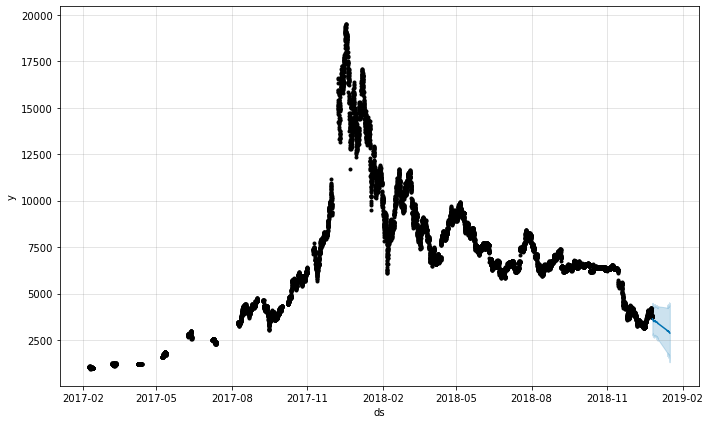

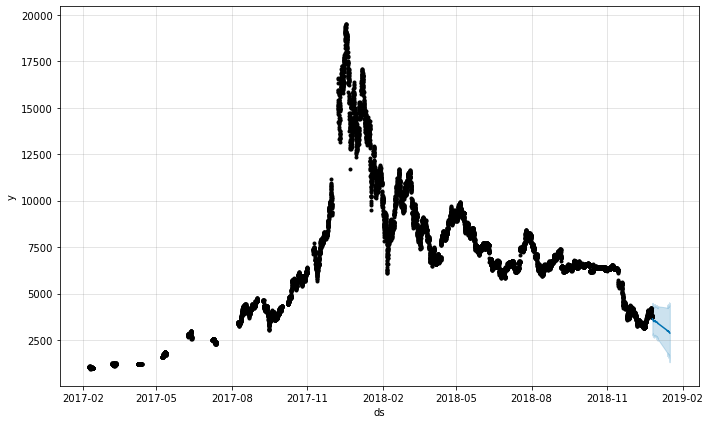

In [125]:
proph.plot(forecast)

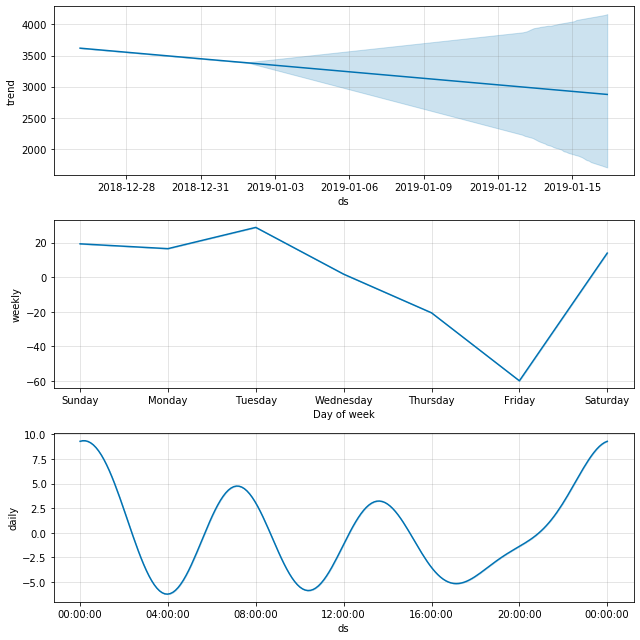

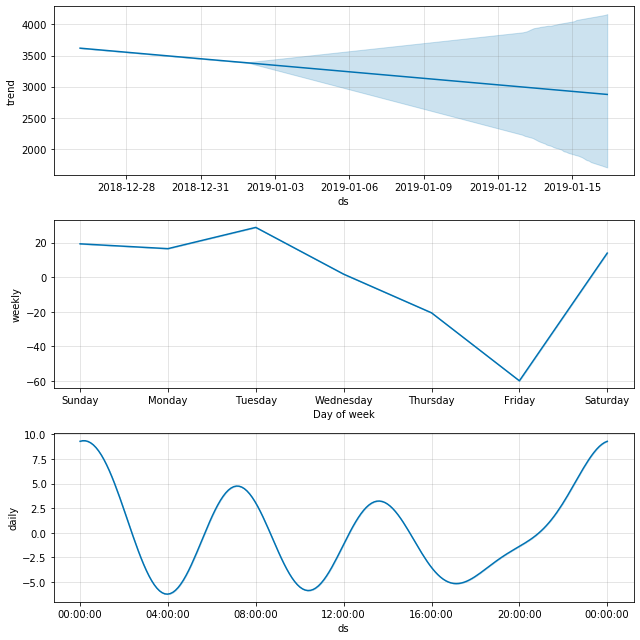

In [126]:
proph.plot_components(forecast)

In [145]:
df_fb = df_bitcoin_inter.copy()
df_fb.reset_index(inplace = True)

In [147]:
df_fb.drop(['index'],axis = 1,inplace = True)

In [137]:
# df_fb.ds.value_counts()

In [148]:
df_vix_inter.reset_index(inplace = True)

In [150]:
df_vix_inter.drop(['index'],axis = 1,inplace = True)

In [151]:
df_fb['vix'] = df_vix_inter['y']

In [152]:
df_vix_inter.isna().sum()

ds    0
y     0
dtype: int64

In [153]:
df_fb['y'].isnull().any()

False

In [132]:
len(df_fb)

12668

In [133]:
len(df_vix_inter)

12668

In [157]:
proph_with_vix = Prophet()

In [158]:
proph_with_vix.add_regressor('vix')

In [159]:
proph_with_vix.fit(df_fb)

In [154]:
df = pd.DataFrame()

In [155]:
df['vix'] = pd.to_numeric(df_fb['vix'])

In [156]:
df['vix']

0        18.879
1        18.915
2        18.860
3        18.770
4        18.770
5        18.878
6        18.887
7        18.887
8        18.887
9        18.887
10       18.887
11       18.887
12       18.887
13       18.887
14       18.887
15       18.887
16       18.887
17       18.887
18       18.887
19       18.887
20       18.887
21       18.887
22       18.805
23       18.769
24       18.619
25       18.600
26       18.579
27       18.419
28       18.360
29       18.499
          ...  
12638    26.631
12639    26.631
12640    26.631
12641    26.631
12642    26.631
12643    26.631
12644    30.447
12645    30.447
12646    30.447
12647    30.447
12648    30.447
12649    30.447
12650    30.447
12651    30.447
12652    30.447
12653    30.447
12654    30.447
12655    30.447
12656    30.447
12657    30.447
12658    30.447
12659    30.447
12660    30.447
12661    30.447
12662    30.447
12663    30.447
12664    30.447
12665    30.447
12666    30.447
12667    30.447
Name: vix, Length: 12668

## Baseline ARIMA model

In [220]:
model = ARIMA(df_train.y, order=(1,0,1)).fit()

### Window refitting model

The make_window_refitting_ARIMA_model is taking a really long time to train, as it is retraining for every new observation.

In [216]:
def make_window_refitting_ARIMA_model(df_t = df_train['y'] , df_v = df_val['y'],p = 1, d = 1, q = 0):
    preds = []
    df_t = list(df_t)

    for i in df_v:
        model = ARIMA(df_t, order=(p,d,q)).fit()
        pred = model.forecast()[0][0]
        preds.append(pred)
        df_t.append(i)

    plt.plot(df_v)
    plt.plot(preds)
    rmse = calc_RMSE(validation,np.array(preds))
    print(rmse)
    
    return rmse,df_v,preds,model

In [34]:
# res = make_window_refitting_model(df_t = df_train['y'], p = 1, d = 0 , q = 1)

In [ ]:
df_val;

## Baseline LSTM Model

In [135]:
# date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df_train.columns[1:]]),
#                           data=[i for i in range(len(df_train.columns[1:]))])

# series_array = df_train[df_train.columns[1:]].values

In [136]:
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

In [137]:
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

In [138]:
def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [156]:
def split_sequence(sequence, n_steps = num_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Standradizing for LSTM

In [189]:
std = StandardScaler()

In [232]:
train = df_train.copy()
train.head()

,ds,y
0,2015-05-31 00:00:00,232.00
1,2015-05-31 01:00:00,231.98
2,2015-05-31 02:00:00,232.14
3,2015-05-31 03:00:00,232.38
4,2015-05-31 04:00:00,232.05


In [677]:
train = df_train.copy()
train = np.array(train.y)[:, np.newaxis]
val = df_val.copy()
val = np.array(val.y)[:, np.newaxis]
std.fit(train)

val = std.transform(val)
train = std.transform(train)

In [678]:
num_steps = 72
n_features = 1

In [261]:
# train = train.y.values

In [262]:
# val = val.y.values

In [679]:
train

array([[-1.88718585],
       [-1.88520962],
       [-1.88445589],
       ...,
       [-1.05454613],
       [-1.03918663],
       [-1.03353979]])

In [680]:
X, y = split_sequence(train, n_steps)

In [681]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [682]:
X

array([[[-1.88718585],
        [-1.88520962],
        [-1.88445589],
        ...,
        [-1.90297738],
        [-1.90442662],
        [-1.9041478 ]],

       [[-1.88520962],
        [-1.88445589],
        [-1.88357347],
        ...,
        [-1.90442662],
        [-1.9041478 ],
        [-1.90520179]],

       [[-1.88445589],
        [-1.88357347],
        [-1.88285958],
        ...,
        [-1.9041478 ],
        [-1.90520179],
        [-1.90563074]],

       ...,

       [[-0.99003498],
        [-0.98620506],
        [-0.9910185 ],
        ...,
        [-1.05209805],
        [-1.04589971],
        [-1.05943617]],

       [[-0.98620506],
        [-0.9910185 ],
        [-0.98511123],
        ...,
        [-1.04589971],
        [-1.05943617],
        [-1.05454613]],

       [[-0.9910185 ],
        [-0.98511123],
        [-0.98262944],
        ...,
        [-1.05943617],
        [-1.05454613],
        [-1.03918663]]])

In [683]:
X_val, y_val = split_sequence(val, n_steps)

In [684]:
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

In [685]:


LSTM_model_1 = Sequential()
LSTM_model_1.add(LSTM(16, activation='relu', input_shape=(num_steps, n_features)))
# LSTM_model_1.add(Dense(8))
# LSTM_model_1.add(LSTM(16, activation='relu'))
LSTM_model_1.add(Dense(1))
LSTM_model_1.compile(optimizer='adam', loss='mse')

In [686]:
LSTM_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


In [687]:
history = LSTM_model_1.fit(X, y, epochs=100, batch_size=128, validation_split=0.25)

Train on 9073 samples, validate on 3025 samples
Epoch 1/100
9073/9073 [==============================] - 6s 667us/step - loss: 0.3970 - val_loss: 0.0382
Epoch 2/100
9073/9073 [==============================] - 4s 472us/step - loss: 0.0168 - val_loss: 0.0053
Epoch 3/100
9073/9073 [==============================] - 5s 527us/step - loss: 0.0063 - val_loss: 0.0024
Epoch 4/100
9073/9073 [==============================] - 5s 533us/step - loss: 0.0053 - val_loss: 0.0023
Epoch 5/100
9073/9073 [==============================] - 5s 556us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 6/100
9073/9073 [==============================] - 5s 497us/step - loss: 0.0046 - val_loss: 0.0017
Epoch 7/100
9073/9073 [==============================] - 4s 484us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 8/100
9073/9073 [==============================] - 5s 530us/step - loss: 0.0172 - val_loss: 0.0124
Epoch 9/100
9073/9073 [==============================] - 5s 573us/step - loss: 0.0399 - val_loss: 0.0063
Epoch 1

9073/9073 [==============================] - 4s 456us/step - loss: 0.0023 - val_loss: 2.7688e-04
Epoch 76/100
9073/9073 [==============================] - 4s 476us/step - loss: 0.0023 - val_loss: 2.8608e-04
Epoch 77/100
9073/9073 [==============================] - 4s 468us/step - loss: 0.0023 - val_loss: 2.3627e-04
Epoch 78/100
9073/9073 [==============================] - 4s 468us/step - loss: 0.0022 - val_loss: 2.1674e-04
Epoch 79/100
9073/9073 [==============================] - 4s 483us/step - loss: 0.0022 - val_loss: 2.5347e-04
Epoch 80/100
9073/9073 [==============================] - 5s 602us/step - loss: 0.0022 - val_loss: 1.7760e-04
Epoch 81/100
9073/9073 [==============================] - 5s 546us/step - loss: 0.0023 - val_loss: 2.2821e-04
Epoch 82/100
9073/9073 [==============================] - 5s 509us/step - loss: 0.0022 - val_loss: 2.2165e-04
Epoch 83/100
9073/9073 [==============================] - 5s 512us/step - loss: 0.0022 - val_loss: 2.3512e-04
Epoch 84/100
9073/9073 

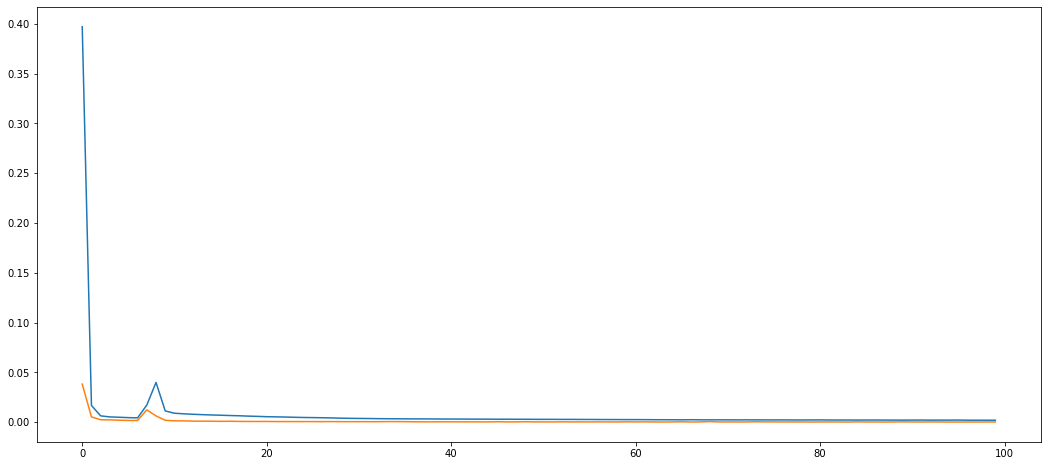

In [688]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [286]:


LSTM_model_2 = Sequential()
LSTM_model_2.add(LSTM(16, activation='relu', input_shape=(num_steps, n_features)))
# LSTM_model_2.add(Dense(8))
# LSTM_model_2.add(LSTM(16, activation='relu'))
LSTM_model_2.add(Dense(1))
LSTM_model_2.compile(optimizer='adam', loss='mse')

In [287]:
history_2 = LSTM_model_2.fit(X, y, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Train on 33769 samples, validate on 619 samples
Epoch 1/100
33769/33769 [==============================] - 17s 507us/step - loss: 0.5075 - val_loss: 0.0034
Epoch 2/100
33769/33769 [==============================] - 15s 452us/step - loss: 0.0148 - val_loss: 5.4571e-04
Epoch 3/100
33769/33769 [==============================] - 15s 452us/step - loss: 0.0019 - val_loss: 3.4029e-04
Epoch 4/100
33769/33769 [==============================] - 16s 465us/step - loss: 0.0012 - val_loss: 2.4501e-04
Epoch 5/100
33769/33769 [==============================] - 16s 460us/step - loss: 9.5149e-04 - val_loss: 2.2599e-04
Epoch 6/100
33769/33769 [==============================] - 16s 461us/step - loss: 9.0372e-04 - val_loss: 2.5732e-04
Epoch 7/100
33769/33769 [==============================] - 16s 464us/step - loss: 8.6225e-04 - val_loss: 2.2103e-04
Epoch 8/100
33769/33769 [==============================] - 16s 465us/step - loss: 8.4849e-04 - val_loss: 2.2583e-04
Epoch 9/100
33769/33769 [===================

Epoch 71/100
33769/33769 [==============================] - 14s 421us/step - loss: 2.5236e-04 - val_loss: 1.0484e-04
Epoch 72/100
33769/33769 [==============================] - 14s 425us/step - loss: 2.5559e-04 - val_loss: 1.0331e-04
Epoch 73/100
33769/33769 [==============================] - ETA: 0s - loss: 2.4983e-0 - 15s 449us/step - loss: 2.5143e-04 - val_loss: 1.1410e-04
Epoch 74/100
33769/33769 [==============================] - 14s 429us/step - loss: 2.5619e-04 - val_loss: 6.7878e-05
Epoch 75/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4696e-04 - val_loss: 6.3019e-05
Epoch 76/100
33769/33769 [==============================] - 14s 422us/step - loss: 2.4641e-04 - val_loss: 8.2700e-05
Epoch 77/100
33769/33769 [==============================] - 14s 420us/step - loss: 2.4503e-04 - val_loss: 6.9561e-05
Epoch 78/100
33769/33769 [==============================] - 14s 421us/step - loss: 2.5311e-04 - val_loss: 6.4097e-05
Epoch 79/100
33769/33769 [==========

In [288]:
LSTM_model_2.save('LSTM_model_2_fit_100epochs.h5')

In [289]:
keras.models.save_model(
    LSTM_model_2,
    'LSTM_model_2_fit_100epochs_2.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [290]:
LSTM_model_3 = Sequential()
LSTM_model_3.add(LSTM(32, activation='relu', input_shape=(num_steps, n_features), dropout=0.05,recurrent_dropout=0.05))
LSTM_model_3.add(Dense(32))
# LSTM_model_3.add(LSTM(16, activation='relu'))
LSTM_model_3.add(Dense(1))
LSTM_model_3.compile(optimizer='adam', loss='mse')



In [291]:
history_3 = LSTM_model_2.fit(X, y, epochs=100, batch_size=128, validation_data=(X_val, y_val))

Train on 33769 samples, validate on 619 samples
Epoch 1/100
33769/33769 [==============================] - 15s 444us/step - loss: 2.4161e-04 - val_loss: 1.4402e-04
Epoch 2/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4129e-04 - val_loss: 8.4394e-05
Epoch 3/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4080e-04 - val_loss: 5.6402e-05
Epoch 4/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4823e-04 - val_loss: 9.6544e-05
Epoch 5/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4032e-04 - val_loss: 5.5833e-05
Epoch 6/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.4110e-04 - val_loss: 5.7477e-05
Epoch 7/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3988e-04 - val_loss: 6.0386e-05
Epoch 8/100
33769/33769 [==============================] - 14s 424us/step - loss: 2.3779e-04 - val_loss: 5.8348e-05
Epoch 9/100
33769/33769 

33769/33769 [==============================] - 14s 422us/step - loss: 2.3628e-04 - val_loss: 5.9544e-05
Epoch 71/100
33769/33769 [==============================] - 14s 422us/step - loss: 2.3330e-04 - val_loss: 6.1796e-05
Epoch 72/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3489e-04 - val_loss: 5.6073e-05
Epoch 73/100
33769/33769 [==============================] - 14s 426us/step - loss: 2.3409e-04 - val_loss: 7.5116e-05
Epoch 74/100
33769/33769 [==============================] - 14s 424us/step - loss: 2.3502e-04 - val_loss: 9.0027e-05
Epoch 75/100
33769/33769 [==============================] - 14s 423us/step - loss: 2.3320e-04 - val_loss: 8.0231e-05
Epoch 76/100
33769/33769 [==============================] - 14s 422us/step - loss: 2.3904e-04 - val_loss: 9.2309e-05
Epoch 77/100
33769/33769 [==============================] - 14s 426us/step - loss: 2.3498e-04 - val_loss: 5.3780e-05
Epoch 78/100
33769/33769 [==============================] - 14s 424us/step - 

In [292]:
LSTM_model_3.save('LSTM_model_3_fit_100epochs.h5')

In [293]:
keras.models.save_model(
    LSTM_model_3,
    'LSTM_model_3_fit_100epochs_2.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [362]:
df_vix_FBP.head()

,ds,y
0,2017-01-25 16:00:00+00:00,19.14
1,2017-01-25 17:00:00+00:00,19.14
2,2017-01-25 18:00:00+00:00,19.14
3,2017-01-25 19:00:00+00:00,19.14
4,2017-01-25 20:00:00+00:00,19.14


In [364]:
df_vix_FBP[df_vix_FBP.ds.isin(intersecting_dates)]

,ds,y
432,2017-02-12 16:00:00+00:00,18.185
433,2017-02-12 17:00:00+00:00,18.185
434,2017-02-12 18:00:00+00:00,18.185
435,2017-02-12 19:00:00+00:00,18.185
436,2017-02-12 20:00:00+00:00,18.185
437,2017-02-12 21:00:00+00:00,18.185
438,2017-02-12 22:00:00+00:00,17.877
439,2017-02-12 23:00:00+00:00,17.840
1103,2017-03-12 17:00:00+00:00,17.000
1104,2017-03-12 18:00:00+00:00,17.000


In [365]:
df_train[df_train.ds.isin(intersecting_dates)]

,ds,y
14044,2017-01-08 00:00:00,902.12
14045,2017-01-08 01:00:00,898.47
14046,2017-01-08 02:00:00,909.53
14047,2017-01-08 03:00:00,916.38
14048,2017-01-08 04:00:00,927.38
14049,2017-01-08 05:00:00,932.42
14050,2017-01-08 06:00:00,933.59
14051,2017-01-08 07:00:00,933.36
14052,2017-01-08 08:00:00,930.09
14053,2017-01-08 09:00:00,931.71
